__1 пункт__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import scipy.integrate as integrate

In [2]:
df = pd.read_csv("owid-covid-data.csv")

In [3]:
df = df[df['iso_code'] == 'RUS'].copy()

In [4]:
df = df[df['date'] >= '2020-03-03'][:50].reset_index().copy()

In [5]:
df_train = df.loc[:, ['total_cases', 'new_cases']]

__2 пункт__

In [6]:
df_train.head()

,total_cases,new_cases
0,3.0,0.0
1,3.0,0.0
2,4.0,1.0
3,13.0,9.0
4,13.0,0.0


In [7]:
train_data = df_train.to_numpy()
train_data = np.column_stack((np.arange(50), train_data))
train_data.shape

(50, 3)

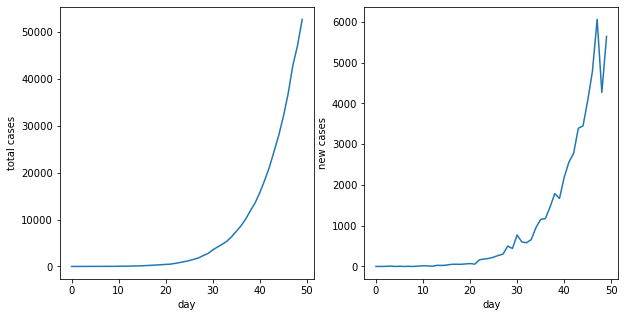

In [8]:
fig = plt.figure(figsize = (10, 5))
tot_cases = fig.add_subplot(1, 2, 1)
new_cases = fig.add_subplot(1, 2, 2)

plt.subplot(121)
tot_cases.plot(train_data[:, 0], train_data[:, 1])
plt.xlabel('day')
plt.ylabel('total cases')

plt.subplot(122)
new_cases.plot(train_data[:, 0], train_data[:, 2])
plt.xlabel('day')
plt.ylabel('new cases')

plt.show()

Использую линейную регрессию, можем вместо зависимости $y = e^{w_0 + w_1 \cdot x}$, обучать 

$ln(y) = w_o + w_1 \cdot x$

In [9]:
length = 50

In [10]:
y = np.log(train_data[:, 1])
X = train_data[:, 0].reshape((length, 1))
X_inter = np.column_stack((np.ones(length), X))
reg = Ridge(alpha=1.0, fit_intercept=False).fit(X_inter, y)
w_0 = reg.coef_[0]
w_1 = reg.coef_[1]
(w_0, w_1)

(1.6899902536460971, 0.20224793642019892)

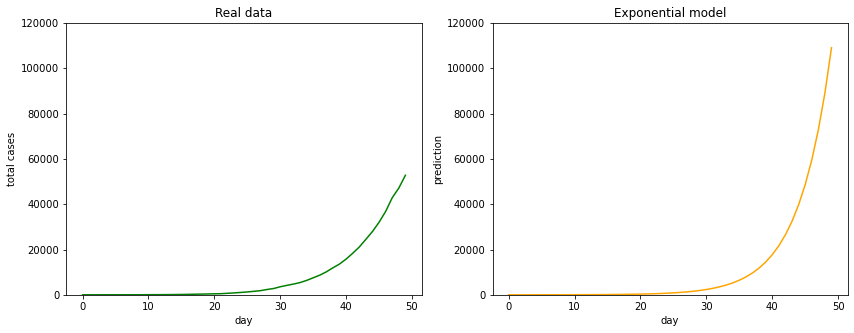

In [11]:
fig = plt.figure(figsize = (14, 5))
real_cases = fig.add_subplot(1, 2, 1)
model_cases = fig.add_subplot(1, 2, 2)

plt.subplot(121)
real_cases.plot(train_data[:, 0], train_data[:, 1], color='green')
plt.xlabel('day')
plt.title('Real data')
plt.ylabel('total cases')
plt.ylim([0, 1.2e5])

plt.subplot(122)
model_cases.plot(X, np.exp(w_0 + w_1 * X), color='orange')
plt.xlabel('day')
plt.title('Exponential model')
plt.ylim([0, 1.2e5])
plt.ylabel('prediction')

plt.show()

Считаем априорное распределение нормальным многомерным, тогда апостериорное распределение $ln(y) \text{  от  } w^Tx$ - тоже нормальное многомерное.

Запишем формулы пересчета: $$\Sigma_N^{-1} = \Sigma_0^{-1} + \frac{1}{\sigma^2}X^T X$$ $$\mu_N = \Sigma_N(\Sigma_0^{-1}\mu_0 + \frac{1}{\sigma^2}X^Ty)$$

Положим $\mu_0 = 0$, а $\Sigma_0 = \sigma^2 E$

Теперь оценим $\sigma^2$

In [12]:
noise = y - (X_inter @ np.array([w_0, w_1])).reshape(len(y))
sigma = np.var(noise)**0.5
Dvar = sigma**2

In [13]:
Dvar

0.1250912482914112

In [14]:
sigma_0 = np.eye(2) * Dvar
sigma_N = np.linalg.inv((np.eye(2) + (X_inter.T @ X_inter))) * Dvar
mu_0 = np.zeros(2)
mu_N = sigma_N @ X_inter.T @ y / Dvar 

In [15]:
(mu_N, sigma_N)

(array([1.68999025, 0.20224794]),
 array([[ 9.01252859e-03, -2.73100171e-04],
        [-2.73100171e-04,  1.13698847e-05]]))

Это и есть параметры апостериорного распределения(2мерного нормального) параметров нашей модели. Среднее совпадает с обученной линейной регрессией из коробки. 

Теперь посэмплируем экспоненты из этого распределения:

In [16]:
def myplot_sample_lines(mu, sigma, n=20, max_day=50):
    # Посэмплируем и порисуем экспоненты
    my_w = np.random.multivariate_normal(mu, sigma, n)

    xs = np.arange(max_day)
    X_new = np.column_stack((np.ones(max_day), xs))
    for w in my_w:
        plt.plot(xs, np.exp(X_new @ w.reshape(2, 1)), 'k-', lw=.4)

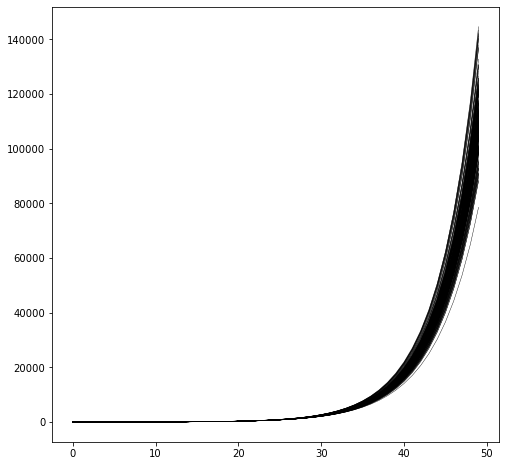

In [17]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
myplot_sample_lines(mu_N, sigma_N, 200)

    Посмотрим сколько ожидается случаев к 1 мая(day 59), 1 июня(day 90), 1 сентября(day 182):

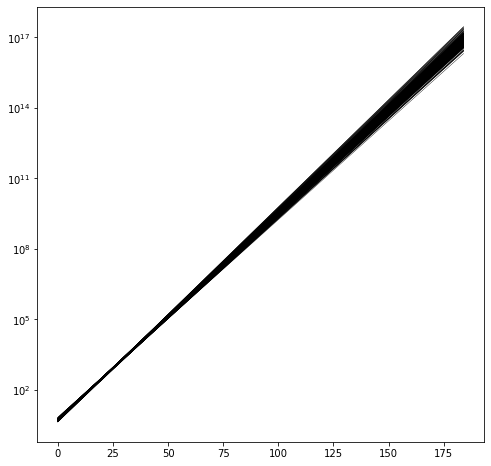

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
myplot_sample_lines(mu_N, sigma_N, n=200, max_day=185)
plt.yscale('log')
#plt.xticks(np.arange(0, 186, 20))

In [19]:
def f(w, day):
    return np.exp(np.dot(w, np.array([1, day])))

In [20]:
cases = [59, 90, 182]
def gen_distribute(days, mu, sigma, n=100):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    ans = {day:[] for day in days}
    for w in my_w:
        for day in days:
            ans[day].append(np.exp(np.dot(w, np.array([1, day]))))
            
    return ans

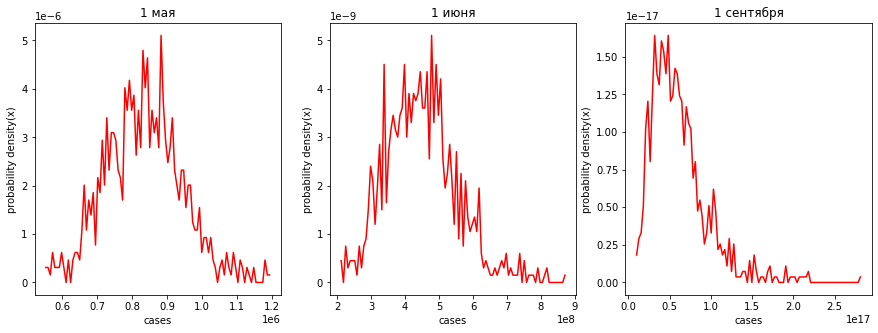

In [21]:
fig = plt.figure(figsize = (15, 5))
case_1 = fig.add_subplot(1, 3, 1)
case_2 = fig.add_subplot(1, 3, 2)
case_3 = fig.add_subplot(1, 3, 3)

N = 1000
dists = gen_distribute(cases, mu_N, sigma_N, N)
n = N // 10

plt.subplot(131)
p, x = np.histogram(dists[cases[0]], bins=n, density=True)
x = x[:-1] + (x[1] - x[0])/2
case_1.plot(x, p, color='red')
plt.xlabel('cases')
plt.title('1 мая')
plt.ylabel('probability density(x)')

plt.subplot(132)
p, x = np.histogram(dists[cases[1]], bins=n, density=True)
x = x[:-1] + (x[1] - x[0])/2
case_2.plot(x, p, color='red')
plt.xlabel('cases')
plt.title('1 июня')
plt.ylabel('probability density(x)')

plt.subplot(133)
p, x = np.histogram(dists[cases[2]], bins=n, density=True)
x = x[:-1] + (x[1] - x[0])/2
case_3.plot(x, p, color='red')
plt.xlabel('cases')
plt.title('1 сентября')
plt.ylabel('probability density(x)')

plt.show()

Можно увидеть, что к 1 мая в среднем будет порядка миллиона случаев, к 1 июня порядка 500 миллионов, а к 1 сентября, аж $10^{17}$ случаев, понятно, что такая модель не репрезентативна и не имеет смысла.

__3 пункт__

Пусть у нас есть зависимость $y = exp\frac{-(x - \mu)^2}{2 \sigma^2}$, из нее можно получить линейную:

$\sqrt{-ln(y)} = \frac{x - \mu}{\sqrt{2} \sigma}$

Конкретно в нашем случае при обучении сигмоиды, можно заметить, что $new\_cases(x)$ - это приращение гауссиана, т.е. можно приближенно записать это как: $total\_ cases(x) = \Phi(x) = \frac{\alpha}{\sqrt{2\pi} \sigma} \int_{-\infty}^{x}e^{\frac{-(t-\mu)^2}{2\sigma^2}} dt$ т.к. x - это дни, то можно приближенно записать:

$new\_ cases(x) = y(x) = \frac{\alpha}{\sqrt{2\pi} \sigma} e^{\frac{-(x-\mu)^2}{2\sigma^2}}$

Несложно понять, что если задать $total\_ cases(x) = \Phi(x) =  \int_{-\infty}^{x}e^{at^2 + bt + c} dt$ - то это будет такое же семейство кривых, и будем искать параметры именно a, b, c

$$new\_cases(x) = y(x) = e^{ax^2 + bx + c}$$

$$ln(y) = ax^2 + bx + c = w_0 + w_1 x + w_2 x^2$$

In [22]:
length = 50

In [23]:
y = train_data[:, 2]
y[np.where(y == 0)[0]] = 1
y = np.log(y)
X = np.column_stack((np.ones(length), train_data[:, 0], train_data[:, 0]**2))
reg = Ridge(alpha=1.0, fit_intercept=False).fit(X, y)
w_0 = reg.coef_[0]
w_1 = reg.coef_[1]
w_2 = reg.coef_[2]
(w_0, w_1, w_2)

(-0.33691197519807004, 0.27069394123050267, -0.001745909808609226)

In [24]:
def f(x):
    return np.exp(w_0 + w_1 * x + w_2 * x**2)

def phi(x, func=f):
    return integrate.quad(func, -np.inf, x)

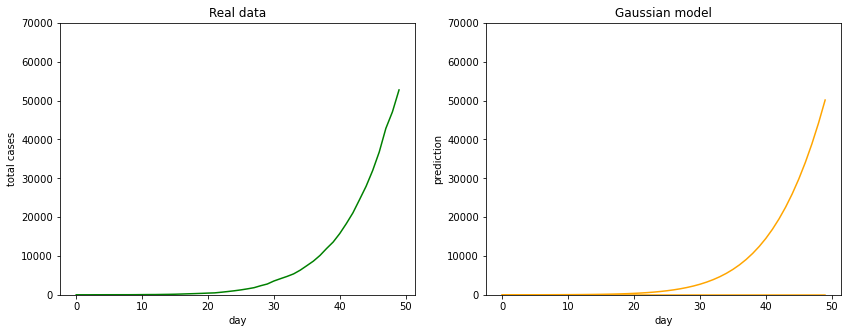

In [25]:
fig = plt.figure(figsize = (14, 5))
real_cases = fig.add_subplot(1, 2, 1)
model_cases = fig.add_subplot(1, 2, 2)

plt.subplot(121)
real_cases.plot(train_data[:, 0], train_data[:, 1], color='green')
plt.xlabel('day')
plt.title('Real data')
plt.ylabel('total cases')
plt.ylim([0, 0.7e5])

plt.subplot(122)
model_cases.plot(X[:, 1], [phi(x) for x in train_data[:, 0]], color='orange')
plt.xlabel('day')
plt.title('Gaussian model')
plt.ylim([0, 0.7e5])
plt.ylabel('prediction')

plt.show()

Считаем априорное распределение нормальным многомерным, тогда апостериорное распределение $ln(y) \text{  от  } w^Tx$ - тоже нормальное многомерное.

Запишем формулы пересчета: $$\Sigma_N^{-1} = \Sigma_0^{-1} + \frac{1}{\sigma^2}X^T X$$ $$\mu_N = \Sigma_N(\Sigma_0^{-1}\mu_0 + \frac{1}{\sigma^2}X^Ty)$$

Положим $\mu_0 = 0$, а $\Sigma_0 = \sigma^2 E$

Теперь оценим $\sigma^2$

In [26]:
noise = y - (X @ np.array([w_0, w_1, w_2])).reshape(len(y))
Dvar = np.var(noise)
sigma = Dvar ** 0.5

In [27]:
Dvar

0.2396702522829309

In [28]:
sigma_0 = np.eye(3) * Dvar
sigma_N = np.linalg.inv((np.eye(3) + (X.T @ X))) * Dvar
mu_0 = np.zeros(3)
mu_N = sigma_N @ X.T @ y / Dvar 

In [29]:
(mu_N, sigma_N)

(array([-0.33691198,  0.27069394, -0.00174591]),
 array([[ 3.41483752e-02, -2.75790291e-03,  4.64201405e-05],
        [-2.75790291e-03,  3.17605773e-04, -6.14505933e-06],
        [ 4.64201405e-05, -6.14505933e-06,  1.27650477e-07]]))

Это и есть параметры апостериорного распределения(3мерного нормального) параметров нашей модели. Среднее совпадает с обученной линейной регрессией из коробки. 

Теперь посэмплируем гауссианы из этого распределения:

In [30]:
def myplot_sample_lines(mu, sigma, n=20, max_day=50):
    # Посэмплируем и порисуем гауссианы
    my_w = np.random.multivariate_normal(mu, sigma, n)

    xs = np.arange(max_day)
    for w in my_w:
        func = lambda x: np.exp(w[0] + w[1] * x + w[2] * x**2)
        plt.plot(xs, [phi(x, func) for x in xs], 'k-', lw=.4)

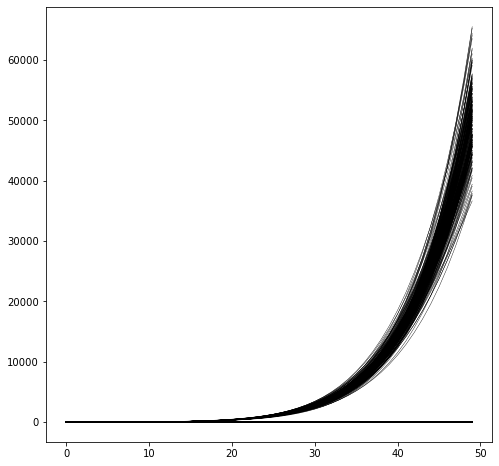

In [31]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
myplot_sample_lines(mu_N, sigma_N, 200)

In [32]:
def gen_distribute(mu, sigma, n=100):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    ans = []
    for w in my_w:
        func = lambda x: np.exp(w[0] + w[1] * x + w[2] * x**2)
        ans.append(phi(np.inf, func)[0])
            
    return ans

Text(0, 0.5, 'probability density(x)')

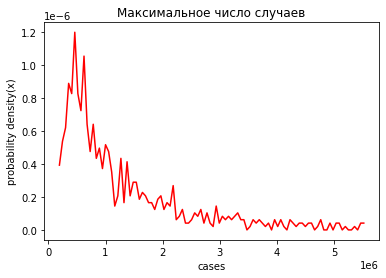

In [33]:
N = 1000
max_cases = gen_distribute(mu_N, sigma_N, N)
n = N // 10


p, x = np.histogram(sorted(max_cases)[:-100], bins=n, density=True)
x = x[:-1] + (x[1] - x[0])/2
plt.plot(x, p, color='red')
plt.xlabel('cases')
plt.title('Максимальное число случаев')
plt.ylabel('probability density(x)')

Получается скорее всего будет порядка миллиона случаев.

In [34]:
print("Пессимистичный сценарий: ", int(np.percentile(max_cases, 90)))
print("Оптимистичный сценарий: ", int(np.percentile(max_cases, 10)))

Пессимистичный сценарий:  5553704
Оптимистичный сценарий:  363176
